# Исследование

## 0. Импорты

In [115]:
import pandas
pandas.__version__

'1.4.4'

In [116]:
import sklearn
sklearn.__version__

'1.1.2'

In [1]:
import pandas as pd
import numpy as np
import gc 
import os.path
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from googlesearch import search 
from urllib.error import HTTPError
from bs4 import BeautifulSoup as bs
import requests

In [2]:
''' подавление предупреждений '''
import warnings
warnings.filterwarnings('ignore')

In [3]:
''' мой модуль '''
from src.projmodul import *

## 1. Прогноз

### 1.1. Подготовка данных

- Используйте датасет из Epicurious, подготовленный HugoDarwood
- Отфильтруйте поля: удалите как можно больше столбцов, которые не относятся к названиями ингридиентов. Вы будете прогнозировать оценку или категорию оценки, используя только ингридиенты и ничего больше. Если модель обучится на других данных, которые не будут передаваться на вход, то точность прогнозов будет заведомо ниже.

----------------------------

#### 1.1.1. Датасет из Epicurious, подготовленный HugoDarwood

In [4]:
df  = pd.read_csv('./data/epi_r.csv')

In [5]:
df.head(2)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.shape

(20052, 680)

In [7]:
df.size

13635360

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB


In [9]:
df.dtypes

title          object
rating        float64
calories      float64
protein       float64
fat           float64
               ...   
cookbooks     float64
leftovers     float64
snack         float64
snack week    float64
turkey        float64
Length: 680, dtype: object

In [10]:
df.describe().round(2)

,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
count,20052.00,15935.00,15890.00,15869.00,15933.00,20052.00,20052.00,20052.00,20052.00,20052.00,...,20052.00,20052.00,20052.00,20052.00,20052.00,20052.00,20052.00,20052.00,20052.00,20052.00
mean,3.71,6322.96,100.16,346.88,6225.97,0.00,0.00,0.00,0.00,0.00,...,0.00,0.03,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.02
std,1.34,359046.04,3840.32,20456.11,333318.19,0.02,0.01,0.03,0.04,0.02,...,0.04,0.16,0.01,0.02,0.12,0.01,0.02,0.04,0.03,0.15
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.75,198.00,3.00,7.00,80.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,4.38,331.00,8.00,17.00,294.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,4.38,586.00,27.00,33.00,711.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,5.00,30111218.00,236489.00,1722763.00,27675110.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,20052.0,3.714467,1.340829,0.0,3.75,4.375,4.375,5.0
calories,15935.0,6322.958017,359046.041242,0.0,198.00,331.000,586.000,30111218.0
protein,15890.0,100.160793,3840.318527,0.0,3.00,8.000,27.000,236489.0
fat,15869.0,346.877497,20456.106859,0.0,7.00,17.000,33.000,1722763.0
sodium,15933.0,6225.974895,333318.188891,0.0,80.00,294.000,711.000,27675110.0
...,...,...,...,...,...,...,...,...
cookbooks,20052.0,0.000150,0.012231,0.0,0.00,0.000,0.000,1.0
leftovers,20052.0,0.000349,0.018681,0.0,0.00,0.000,0.000,1.0
snack,20052.0,0.001396,0.037343,0.0,0.00,0.000,0.000,1.0
snack week,20052.0,0.000948,0.030768,0.0,0.00,0.000,0.000,1.0


In [12]:
df.describe().T['max'].max()

30111218.0

In [14]:
sum(df['title'].duplicated())

2316

In [15]:
df[df.duplicated(subset=['title'])]

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
229,Blackberry-Raspberry Sauce,0.000,172.0,2.0,1.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340,Seasoned Nori Wrappers,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
521,Spiced Pita Toasts,3.750,21.0,0.0,1.0,38.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,Orange Balsamic Glaze,3.750,194.0,2.0,3.0,697.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
717,Garlic Baguette Crumbs,0.000,95.0,1.0,7.0,103.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20039,Cauliflower Purée,3.125,364.0,11.0,28.0,642.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20041,Chicken with White Wine and Herbs,2.500,843.0,59.0,59.0,351.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20042,Date Purée,2.500,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20045,Blueberry Compote,3.750,182.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df['title'].isin(['Date Purée ']).any()

True

In [17]:
df.loc[df['title'] == 'Date Purée ']

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
18783,Date Purée,2.5,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20042,Date Purée,2.5,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df['rating'].value_counts()

4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: rating, dtype: int64

In [19]:
df['rating'].value_counts(normalize=True)

4.375    0.399910
3.750    0.257780
5.000    0.135597
0.000    0.091562
3.125    0.074257
2.500    0.026531
1.250    0.008179
1.875    0.006184
Name: rating, dtype: float64

#### 1.1.2. Получить описание ингредиентов

##### 1.1.2.1 С сайта API

- https://fdc.nal.usda.gov/download-datasets.html
- https://www.ars.usda.gov/northeast-area/beltsville-md-bhnrc/beltsville-human-nutrition-research-center/food-surveys-research-group/docs/fndds-download-databases/

In [28]:
# xl = pd.ExcelFile("./my_data/2019-2020 FNDDS At A Glance - FNDDS Ingredients.xlsx")
xl = pd.ExcelFile("./my_data/2019-2020 FNDDS At A Glance - FNDDS Nutrient Values.xlsx")
print(xl.sheet_names) # какие таблицы загрузились

['FNDDS Nutrient Values', 'Variable Descriptions']


In [29]:
name_tables = 'FNDDS Nutrient Values' # 'FNDDS Ingredients'
df_xl = xl.parse(name_tables, header=1)
df_xl.head(3)

,Food code,Main food description,WWEIA Category number,WWEIA Category description,Energy (kcal),Protein (g),Carbohydrate (g),"Sugars, total\n(g)","Fiber, total dietary (g)",Total Fat (g),...,20:1\n(g),22:1\n(g),18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g)
0,11000000,"Milk, human",9602,Human milk,70,1.03,6.89,6.89,0.0,4.38,...,0.040,0.0,0.374,0.052,0.0,0.026,0.000,0.000,0.0,87.50
1,11100000,"Milk, NFS",1004,"Milk, reduced fat",52,3.33,4.83,4.88,0.0,2.14,...,0.002,0.0,0.074,0.008,0.0,0.003,0.000,0.001,0.0,88.92
2,11111000,"Milk, whole",1002,"Milk, whole",61,3.27,4.63,4.81,0.0,3.20,...,0.004,0.0,0.115,0.013,0.0,0.004,0.001,0.002,0.0,88.10


In [30]:
# Столбец с наиболее подходящим описанием ингредиентов
name_column = 'Main food description' # 'Ingredient description'
df_xl = df_xl[[name_column]] # в датасете один столбец
df_xl.head(3)

,Main food description
0,"Milk, human"
1,"Milk, NFS"
2,"Milk, whole"


In [31]:
len(df_xl)

5624

In [32]:
df_xl.loc[len(df_xl), 'Main food description'] = "saffron"
df_xl.loc[len(df_xl), 'Main food description'] = "chile pepper"

In [33]:
df_xl

,Main food description
0,"Milk, human"
1,"Milk, NFS"
2,"Milk, whole"
3,"Milk, reduced fat (2%)"
4,"Milk, low fat (1%)"
...,...
5621,Vegetables as ingredient in curry
5622,Sauce as ingredient in hamburgers
5623,Industrial oil as ingredient in food
5624,saffron


##### 1.1.2.2 Pir-to-Pir

400 с лишним ингредиентов  от pir-to-pir

In [34]:
# 400 с лишним ингредиентов  от pir-to-pir
# ----------------------------------------
df_xl = pd.read_csv('./my_data/list_ingr.csv')

#### 1.1.3. Создание и применение пайплайна препроцессинга

In [35]:
preprocessing = Pipeline([
    ('feature_extractor', FeatureExtractor(
        df_xl, # датафрейм с одной колонкой, содержащей описание ингредиентов
        ['title','rating'], # список колонок которые должны остаться после фильтрации
        clear=False, # флаг, управляющий очисткой фильтра
        strong=True, # флаг, управляющий типом фильтрации столбцов
        select_imp=False # True - применить алгоритм RFECV для отбора наиболее значимых признаков
        )), 
    ('clear_dataset', DatasetCleaner(
        'rating', # имя столбца таргета (y)
        'title', # список игнорируемых при некторых операциях столбцов
        zero_del=False # Удаляет Строки где таргет равен 0
        )),
    ])

X, y, title = preprocessing.fit_transform(df)

In [36]:
# Создать новый, очищенный датасет для удобства
df_fine = pd.concat([title, X, y], axis=1)
# Сохранить очищенный датасет
df_fine.to_csv('./data/df_fine.csv', index=False)
# Сохранить список имен признаков
saving_model(X.columns.to_list(), './data/feature.d15')

Models saved!


In [37]:
print("X:", X.shape, "\ny:", y.shape, "\ntitle:", title.shape)

X: (18210, 409) 
y: (18210,) 
title: (18210,)


In [38]:
y.value_counts(normalize=True)

4.375    0.403844
3.750    0.260901
5.000    0.130588
0.000    0.090170
3.125    0.074355
2.500    0.026359
1.250    0.007853
1.875    0.005931
Name: rating, dtype: float64

In [39]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
almond,18210.0,0.030093,0.170849,0.0,0.0,0.0,0.0,1.0
amaretto,18210.0,0.002032,0.045031,0.0,0.0,0.0,0.0,1.0
anchovy,18210.0,0.002361,0.048538,0.0,0.0,0.0,0.0,1.0
anise,18210.0,0.005656,0.074997,0.0,0.0,0.0,0.0,1.0
anniversary,18210.0,0.006041,0.077489,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
green onion/scallion,18210.0,0.005986,0.077138,0.0,0.0,0.0,0.0,1.0
hominy/cornmeal/masa,18210.0,0.004338,0.065724,0.0,0.0,0.0,0.0,1.0
phyllo/puff pastry dough,18210.0,0.006809,0.082240,0.0,0.0,0.0,0.0,1.0
soufflé/meringue,18210.0,0.000165,0.012835,0.0,0.0,0.0,0.0,1.0


In [40]:
X.describe().T['max'].max()

1.0

In [41]:
tvt = TrainValidationTest(X, y)
X_train, X_valid, X_test, y_train, y_valid, y_test = tvt.get_TVT()

In [151]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, stratify=y, test_size=0.2, random_state=21)

- Очистка памяти

In [42]:
%reset_selective -f df
%reset_selective -f xl

### ФУНКЦИИ

In [43]:
# Функция сохранения группы обученных моделей
# -------------------------------------
def saved_models(models, results, file_path, refit, X_train, y_train):
    ''' 
    Сохраняет список моделей, предварительно обучив их.
    Принимает:
        models: список моделей
        results: датафрейм с результатами подбора гиперпараметров
        file_path: путь сохранения моделей
        refit: нужно ли обучать модели перед сохранением
        X_train, y_train: выборки для обучения моделей перед сохранением
    '''
    
    # обучить
    if refit:
        for i in range(len(models)): # Взять лучшие модели
            print(type(models[i]).__name__)
            params = {} if results["params"][i]=={} else eval(results["params"][i])
            models[i].set_params(**params) # Установить лучшие гиперпараметры
            models[i].fit(X_train, y_train) # Обучить на тренировочных сетах

    # сохранить
    saving_model(models, file_path)
    
    return models
# -- Time: 3.21 m -- #

In [44]:
# Функция запускает функции-селекторы, сохраняет/загружает отчет и модели
# -------------------------------------
def run_select(
    X_train, y_train, X_test, y_test, 
    file_path, 
    mod_path,     
    select, 
    models, 
    params, 
    gs_type, 
    score, 
    cv,
    scor_test,
    time_drop = True
    ):
    ''' 
    Если отсутствует файл отчета, то нужно провести исследование. Файл отчета должен сохраняться в любом случае. При загрузке должен загружаться файла отчета обязательно, а файл моделей по требованию. Файл моделей сохраняется по требованию.
    
    Получает:
    X_train, y_train, X_test, y_test,
    
    file_path: путь_имя файла с исследованием

    mod_path: путь_имя файла с обученными моделями.
        'No' - не сохранять и не загружать модели
        Любая строка кроме 'No' расценивается как путь к файлу - если файл существует, то он будет загружен, если нет, то модели будут сохранены

    select: имя функции-селектора
    
    Параметры для select: см. ф-ию select

    time_drop: удалять ли из вывода потраченное на обучение модели время
        False - нет
        True - удалять
    
    Возвращает:
    result: результат исследования сортированый по метрике на тесте
    models: обученные или НЕ обученные модели расположенные в порядке ухудшения метрики на  тесте
    '''
    # ОТЧЕТ
    if os.path.isfile(file_path):
        result = pd.read_csv(file_path)
    else:
        result = select(
            X_train, y_train, X_test, y_test, 
            models, 
            params, 
            gs_type, 
            score, 
            cv, 
            scor_test
            )
        result.to_csv(file_path, index=False)
    
    # расположить модели в порядке отчета
    models = [models[result.index[i]] for i in range(len(models))]

    # МОДЕЛИ
    if mod_path != 'No': # модель нужно сохранить или загрузить
        if os.path.isfile(mod_path): # если существует - загрузить
            models = loading_model(mod_path)
            # models = pickle.load(open(mod_path, 'rb'))
        else: # если не существует - обучить и сохранить
            refit = True # переобучать
            if gs_type == "gspb":
                refit = False # уже обученные

            saved_models(models, result, mod_path, refit, X_train, y_train)

    # Убрать из вывода результатов время
    if time_drop:
        result.drop('time', axis=1, inplace=True)
    
    if scor_test is False:
        result.drop('test_score',axis=1,inplace=True)
        result.sort_values(by='train_score', ascending=False, inplace=True)

    return result, models

In [45]:
# Функция-селектор ищет лучшие алгоритмы и модели
# -------------------------------------
def m_select(
    X_train, y_train, X_test, y_test,
    models, 
    params, 
    gs_type, 
    score, 
    cv, 
    scor_test
    ):
    '''
    Получает:
    X_train, y_train, X_test, y_test

    models: список моделей

    params: соответствующий моделям, список парметров моделей

    gs_type: тип GridSearch - 
        gscv: GridSearchCV, 
        gsrn: RandomizedSearchCV,
        gspb: GridSearchPB

    score: метрика для GridSearch

    cv: количество фолдов кросс-валидации

    scor_test: проводить ли проверку метрики на тестовых данных

    Возвращает:
    result: результат исследования
    '''
    # Создать список объектов GridSearch и словарь с названиями алгоритмов
    grids, grid_dict = gsList(
        models, 
        params, 
        gs_type, # gscv: GridSearchCV(), gspb: GridSearchPB()
        score,#'neg_root_mean_squared_error',#
        cv=cv, 
        verbose=0, 
        n_jobs=-1
    )
    # Выбрать лучшие алгоритмы
    ms = ModelSelection(
        grids, 
        grid_dict, 
        scor_test=scor_test,
        prt_mode=True
        )
    ms.choose(X_train, y_train, X_test, y_test)
    result = ms.best_results()
    
    return result

---------------------------

### 1.2. Регрессия

- Для прогнозирования рейтинга опробуйте различные алгоритмы и их гиперпараметры. Выберите лучшее решение на основе gridsearch и кроссвалидации и оцените RMSE на тестовой подвыборке.
- Попробуйте различные ансамбли и их гиперпараметры. Выберите лучшее решение на основе gridsearch и кроссвалидации и оцените RMSE на тестовой подвыборке.
- Посчитайте RMSE для наивного регрессора, в котором вы просто высчитали средний рейтинг.

----------------------------------

#### 1.2.0 Импорты

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LarsCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.dummy import DummyRegressor
# 
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

#### 1.2.1 Выбор индивидальной модели

Для прогнозирования рейтинга опробуйте различные алгоритмы и их гиперпараметры. Выберите лучшее решение на основе gridsearch и кроссвалидации и оцените RMSE на тестовой подвыборке.

##### 1.2.1.1 Выбор алгоритма регрессионной модели

In [47]:
algs_reg = []
set_algs_reg = []
# Линейные алгоритмы:
algs_reg.append(Ridge())
set_algs_reg.append({})
algs_reg.append((Lasso()))
set_algs_reg.append({})
algs_reg.append(ElasticNet())
set_algs_reg.append({})
algs_reg.append(LarsCV())
set_algs_reg.append({})
algs_reg.append(BayesianRidge())
set_algs_reg.append({})
algs_reg.append(RidgeCV())
set_algs_reg.append({})
# Нелинейные алгоритмы:
algs_reg.append(KNeighborsRegressor())
set_algs_reg.append({})
algs_reg.append(DecisionTreeRegressor())
set_algs_reg.append({})
algs_reg.append((LinearSVR()))
set_algs_reg.append({})
# # Ансамблевые алгоритмы:
algs_reg.append(GradientBoostingRegressor())
set_algs_reg.append({})
algs_reg.append(RandomForestRegressor()) # долго
set_algs_reg.append({})

- https://habr.com/ru/post/475552/

In [48]:
#  Алгоритмы для регрессоров
# ? -----------------------------------
res_a, mod_a = run_select(
    X_train, y_train, X_valid, y_valid,
    './results/reg_best_alg.csv', 
    'No',
    m_select,
    algs_reg, 
    set_algs_reg, 
    'gscv', 
    'r2', 
    cv=10,
    scor_test=True, # проводить проверку на валидационной выборке
    time_drop=False # не удалять из вывода время на поиск
)
res_a
# ? -----------------------------------

,model,test_score,train_score,time,params
0,LarsCV,0.08891,0.11096,3.577,{}
1,BayesianRidge,0.08641,0.12195,1.803,{}
2,RidgeCV,0.08467,0.11878,1.894,{}
3,GradientBoostingRegressor,0.08231,0.10766,9.920,{}
4,Ridge,0.07933,0.10498,0.359,{}
5,Lasso,-0.00000,-0.00044,0.344,{}
6,ElasticNet,-0.00000,-0.00044,0.315,{}
7,LinearSVR,-0.03360,0.00551,0.424,{}
8,RandomForestRegressor,-0.04012,0.00710,136.664,{}
9,KNeighborsRegressor,-0.19710,-0.15422,0.925,{}


##### 1.2.1.2 Подбор гиперпараметров регрессионной модели 

In [49]:
res_reg_m = []
mod_reg_m = []
# -----------------------------------------------------
res_reg_m.append(BayesianRidge())
# 
mod_reg_m.append({
    'n_iter':[100, 200, 300, 400, 500],
    'compute_score':[False, True],
    'fit_intercept':[True, False],
    'normalize':[False, True],
    'copy_X':[True, False], 
    'verbose':[False, True],
})
# -----------------------------------------------------
res_reg_m.append(RidgeCV())
mod_reg_m.append({
    'alphas':np.arange(0.1, 1, 0.01),
    'fit_intercept':[True,False], 
    'normalize':[True,False],
})
# -----------------------------------------------------
res_reg_m.append(GradientBoostingRegressor(random_state=21))
mod_reg_m.append({
    "learning_rate":np.logspace(-3, 1, 4),
    "n_estimators":[int(x) for x in np.linspace(50, 200, 3)],
    "min_samples_split":[int(x) for x in np.linspace(2, 15, 3)],
    "min_samples_leaf":[int(x) for x in np.linspace(1, 15, 3)],
    "max_depth":[int(x) for x in np.linspace(3, 20, 3)],
})
# -----------------------------------------------------
res_reg_m.append(LarsCV())
mod_reg_m.append({
    'max_iter':[200, 300, 400, 500, 600],
    'fit_intercept':[True, False],
    'normalize':[True, False],
    'max_n_alphas':[600, 800, 1000, 1200,1400], 
    'cv':[5, 6, 7, 8, 9, 10],
})


In [50]:
#  Гиперпараметры для регрессоров
# ? -----------------------------------
res_m, mod_m = run_select(
    X_train, y_train, X_test, y_test,
    './results/reg_best_model.csv', 
    './results/reg_best_model.sav',
    m_select,
    res_reg_m, 
    mod_reg_m, 
    'gsrn',
    'neg_root_mean_squared_error', 
    cv=5,
    scor_test=True, # проводить проверку на тесте
)
res_m
# ? -----------------------------------

,model,test_score,train_score,params
0,BayesianRidge,-1.24983,-1.26307,"{'verbose': False, 'normalize': False, 'n_iter..."
1,RidgeCV,-1.25001,-1.26528,"{'normalize': True, 'fit_intercept': True, 'al..."
2,LarsCV,-1.25115,-1.26270,"{'normalize': False, 'max_n_alphas': 1200, 'ma..."
3,GradientBoostingRegressor,-1.25239,-1.26911,"{'n_estimators': 50, 'min_samples_split': 15, ..."


##### 1.2.1.3 Оценка RMSE на тестовой выборке для лучшей модели

In [51]:
print("RMSE на тестовой подвыборке для лучшей модели: %0.5f" % res_m['test_score'][0])

RMSE на тестовой подвыборке для лучшей модели: -1.24983


#### 1.2.2 Ансамбли

Попробуйте различные ансамбли и их гиперпараметры. Выберите лучшее решение на основе gridsearch и кроссвалидации и оцените RMSE на тестовой подвыборке.

##### 1.2.2.1 Обучить лучшие модели перед использованием в ансамблях

`Модели уже обучены и сохранены на предыдущем этапе внутри ф-ии run_select()`

##### 1.2.2.2 Подбор гиперпараметров для ансамблей регрессоров

In [52]:
ensembles = []
e_params = []

estimators = [
    ('bridge',mod_m[0]),
    ('ridgecv',mod_m[1]),
    ('larscv',mod_m[2]),
    ('gbreg',mod_m[3])]

skfolds = []
for i in range(2, 10):
    skfolds.append(KFold(n_splits=i, shuffle=False))

# -----------------------------------------------------
ensembles.append(StackingRegressor(estimators=estimators))
e_params.append({
    'final_estimator': [
        RidgeCV(), 
        GradientBoostingRegressor(),
        KNeighborsRegressor()
        ],
    'cv': skfolds,
})
# -----------------------------------------------------
ensembles.append(VotingRegressor(estimators=estimators))
e_params.append({
    'weights': [[1,2,3,4],[4,3,2,1],[2,3,4,1],[3,4,1,2]],
})
# -----------------------------------------------------
ensembles.append(BaggingRegressor(random_state=21))
e_params.append({
    'base_estimator': mod_m, 
    'n_estimators': np.arange(1, 10, 1)**2,
})

In [53]:
#  Гиперпараметры для ансамблей регрессоров
# ? -----------------------------------
res_e, mod_e = run_select(
    X_train, y_train, X_test, y_test,
    './results/reg_best_ensembles.csv', 
    './results/reg_best_ensembles.sav',
    m_select,
    ensembles, 
    e_params, 
    'gsrn', 
    'neg_root_mean_squared_error', 
    cv=5,
    scor_test=True, # проводить проверку на тесте
)
res_e
# ? -----------------------------------

,model,test_score,train_score,params
0,StackingRegressor,-1.24597,-1.25890,"{'final_estimator': RidgeCV(), 'cv': KFold(n_s..."
1,VotingRegressor,-1.24734,-1.25980,"{'weights': [3, 4, 1, 2]}"
2,BaggingRegressor,-1.25021,-1.26361,"{'n_estimators': 49, 'base_estimator': RidgeCV()}"


##### 1.2.2.3 Оценка RMSE на тестовой подвыборке для лучшего ансамбля 

In [54]:
print("RMSE на тестовой подвыборке для лучшего ансамбля: %0.5f" % res_e['test_score'][0])

RMSE на тестовой подвыборке для лучшего ансамбля: -1.24597


##### 1.2.2.4 Сохранить лучшую модель для использования в программе

In [165]:
# ------------------------------------------
#  Сохранение модели
# ------------------------------------------
# saving_model(mod_e[0], './models/reg_best.sav')

Models saved!


#### 1.2.3 RMSE для наивного регрессора

Посчитайте RMSE для наивного регрессора, в котором вы просто высчитали средний рейтинг

In [55]:
y_pred_n = np.mean(y_train)
print("RMSE на тестовой подвыборке для наивного регрессора: %0.5f" % rmse(y_test, y_pred_n))

RMSE на тестовой подвыборке для наивного регрессора: -1.32974


Метрики регрессоров с подобранными гиперпараметрами не существенно отличаются от метрики наивного прогноза

### 1.3 Классификация

- Бинаризируйте значения целевой переменной путем округления рейтингов до ближайшего целого числа. Это и будут ваши классы.
- Для прогнозирования классов попробуйте различные алгоритмы и их гиперпараметры. Выберите лучшее решение на основе gridsearch и кроссвалидации и посчитайте accuracy на тестовой подвыборке.
- Рассчитайте значение accuracy наивного классификатора, в котором вы для всех наблюдений прогнозируете наиболее распространенный класс. Сравните метрики.
- Снова проведите бинаризацию целевого столбца, преобразовав теперь целые числа в классы bad (0, 1) (невкусное), so-so (2, 3) (нормальное), great (4, 5) (вкусное).
- Снова для прогнозирования классов попробуйте различные алгоритмы и их гиперпараметры. Выберите лучшее решение на основе кроссвалидации и посчитайте accuracy на тестовой подвыборке.
- Снова рассчитайте значение accuracy наивного классификатора, в котором вы для всех наблюдений прогнозируете наиболее распространенный класс. Сравните метрики.
- Что хуже: спрогнозировать плохой рейтинг, который на самом деле окажется хорошим, или спрогнозировать хороший рейтинг, который на самом деле окажется плохим? Замените метрику accuracy другой соответствующей метрикой.
- Для прогнозирования классов с новой метрикой опробуйте различные алгоритмы и их гиперпараметры. Выберите лучшее решение и посчитайте метрику на тестовой подвыборке.
- Попробуйте различные ансамбли и их гиперпараметры. Выберите лучшее решение и посчитайте метрику на тестовой подвыборке.

---------------------------------------

#### 1.3.0. Импорты

In [56]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.utils import resample ## Used for sampling the data

#### 1.3.1 Бинаризация значения целевой переменной путем округления рейтингов до ближайшего целого числа

In [57]:
y = np.round(y).astype('int8')

tvt = TrainValidationTest(X, y)
X_train, X_valid, X_test, y_train, y_valid, y_test = tvt.get_TVT()

# Датафрейм с новым таргетом для удобства
df_bin = pd.concat([title, X, y], axis=1)
y_bin = y # 

In [58]:
y.value_counts()

4    12105
5     2378
0     1642
3     1354
2      588
1      143
Name: rating, dtype: int64

In [59]:
y.value_counts(normalize=True)

4    0.664745
5    0.130588
0    0.090170
3    0.074355
2    0.032290
1    0.007853
Name: rating, dtype: float64

`Классы сильно несбалансированы!`

#### 1.3.2 Выбор индивидальной модели

- Для прогнозирования классов попробуйте различные алгоритмы и их гиперпараметры. Выберите лучшее решение на основе gridsearch и кроссвалидации и посчитайте accuracy на тестовой подвыборке.

##### 1.3.2.1 Выбор алгоритма классификатора

In [60]:
algs_clf = []
set_algs_clf = []
# Линейные алгоритмы:
algs_clf.append(RidgeClassifier()) 
set_algs_clf.append({})
algs_clf.append((LogisticRegression()))
set_algs_clf.append({})
algs_clf.append((LinearDiscriminantAnalysis()))
set_algs_clf.append({})
# Нелинейные алгоритмы:
algs_clf.append((KNeighborsClassifier()))
set_algs_clf.append({})
algs_clf.append((DecisionTreeClassifier()))
set_algs_clf.append({})
# algs_clf.append((LinearSVC()))
# set_algs_clf.append({})
algs_clf.append((SVC()))
set_algs_clf.append({})
# Алгоритм искусственной нейронной сети:
algs_clf.append((MLPClassifier()))
set_algs_clf.append({})
# Ансамблевые алгоритмы:
algs_clf.append((AdaBoostClassifier(algorithm='SAMME')))
set_algs_clf.append({})
algs_clf.append((RandomForestClassifier()))
set_algs_clf.append({})
algs_clf.append((BaggingClassifier()))
set_algs_clf.append({})
algs_clf.append((ExtraTreesClassifier()))
set_algs_clf.append({})
algs_clf.append((GradientBoostingClassifier()))
set_algs_clf.append({})

In [61]:
#   1. Алгоритмы для y_bin
# ? -----------------------------------
res_clf_a, mod_clf_a = run_select(
    X_train, y_train, X_valid, y_valid,
    './results/clf_best_alg.csv', 
    'No',
    m_select,
    algs_clf, 
    set_algs_clf, 
    'gscv', 
    'accuracy', 
    cv=10,
    scor_test=True, # проводить проверку на валидац. выборке
    time_drop=False # не удалять из вывода время на поиск
)
res_clf_a

,model,test_score,train_score,time,params
0,SVC,0.68418,0.68058,93.668,{}
1,LogisticRegression,0.67859,0.67857,2.079,{}
2,RidgeClassifier,0.67831,0.67744,1.980,{}
3,GradientBoostingClassifier,0.67831,0.67421,34.522,{}
4,AdaBoostClassifier,0.67496,0.67395,2.753,{}
5,LinearDiscriminantAnalysis,0.67077,0.66643,1.212,{}
6,RandomForestClassifier,0.63946,0.63123,7.769,{}
7,KNeighborsClassifier,0.62493,0.62145,0.757,{}
8,MLPClassifier,0.60732,0.59333,51.045,{}
9,ExtraTreesClassifier,0.60704,0.60608,10.691,{}


##### 1.3.2.2 Подбор гиперпараметров классификаторов

In [62]:
mdls_clf = []
set_mdls_clf = []
# ---------------------------
mdls_clf.append(SVC(probability=True, random_state=21))
set_mdls_clf.append( {
    'kernel': ("linear", 'rbf', 'sigmoid'), 
    'C': np.logspace(-2, 2, 5),   
    'gamma': ['scale', 'auto'],
})
# ---------------------------
mdls_clf.append(LogisticRegression(random_state=21))
set_mdls_clf.append({
    'penalty' : ['l1', 'l2', 'none'],
    'C' : np.logspace(-2, 1, 10),
    'fit_intercept' : [True, False],
    'solver' : ['saga'],
    'max_iter':  [int(x) for x in np.linspace(50, 1000, 5)],
    'class_weight':['balanced', None],
})
# ---------------------------
mdls_clf.append(GradientBoostingClassifier(random_state=21))
set_mdls_clf.append({
    'learning_rate': np.logspace(-3, 1, 4),
    'n_estimators': [int(x) for x in np.linspace(50, 200, 3)],
    'min_samples_split': [int(x) for x in np.linspace(2, 50, 3)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 50, 3)],
    'max_depth': [int(x) for x in np.linspace(3, 15, 3)],
})
# ---------------------------
mdls_clf.append(RidgeClassifier(random_state=21))
set_mdls_clf.append({
    "alpha": np.logspace(-3, 1, 5),
    "fit_intercept": [True, False],
    "normalize": [False, True],
    "copy_X": [True, False],
    "max_iter": [int(x) for x in np.linspace(50, 10000, 3)],
    "tol": np.logspace(-5, 0, 4),
    "class_weight": ['balanced', None],
    # "solver": [],
    "positive": [False, True],
    # "random_state": [],
})


In [63]:
#   1. Гиперпараметры для y_bin
# ? -----------------------------------
res_clf_m, mod_clf_m = run_select(
    X_train, y_train, X_test, y_test,
    './results/clf_best_mod.csv', 
    './results/clf_best_mod.sav',
    m_select,
    mdls_clf, 
    set_mdls_clf, 
    'gsrn', 
    'accuracy', 
    cv=5,
    scor_test=True, 
    time_drop=False
)
res_clf_m
# ? -----------------------------------

,model,test_score,train_score,time,params
0,SVC,0.68418,0.68041,1259.024,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0}"
1,LogisticRegression,0.68139,0.67849,111.543,"{'solver': 'saga', 'penalty': 'l2', 'max_iter'..."
2,GradientBoostingClassifier,0.67943,0.67622,343.273,"{'n_estimators': 125, 'min_samples_split': 2, ..."
3,RidgeClassifier,0.67859,0.67831,1.142,"{'tol': 0.0004641588833612782, 'positive': Fal..."


Топ-20 важных признаков

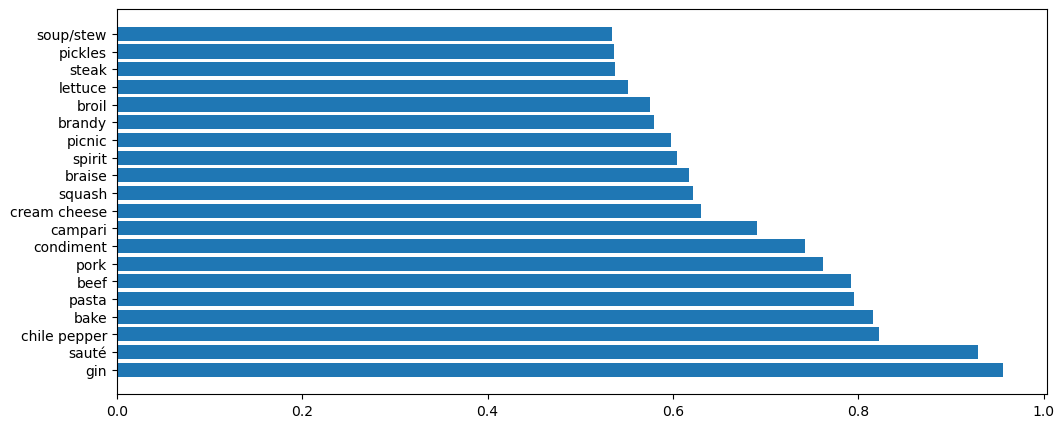

In [64]:
f_importances(abs(mod_clf_m[1].coef_[0]), X_train.columns, top=20)

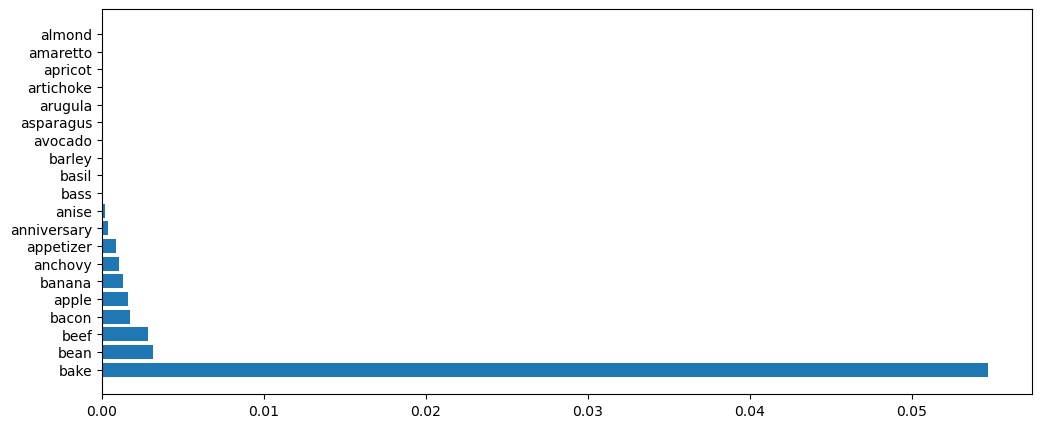

In [65]:
f_importances(abs(mod_clf_m[2].feature_importances_[0:20]), X_train.columns, top=20)

#### 1.3.3 Рассчитайте значение accuracy наивного классификатора, в котором вы для всех наблюдений прогнозируете наиболее распространенный класс. Сравните метрики.

In [66]:
top_class = y_train.value_counts()[:1].index.tolist()[0]
acc_naiv_clf = sum(y_test == top_class)/len(y_test)
print("Значение accuracy наивного классификатора: %0.5f" % acc_naiv_clf)

Значение accuracy наивного классификатора: 0.66474


Метрики классификаторов с подобранными гиперпараметрами не существенно отличаются от метрики наивного прогноза

#### 1.3.4 Снова проведите бинаризацию целевого столбца, преобразовав теперь целые числа в классы bad (0, 1) (невкусное), so-so (2, 3) (нормальное), great (4, 5) (вкусное).

In [67]:
cut_labels = ['bad', 'so-so', 'great']
cut_bins = [0, 2, 4, 6]

y = pd.cut(y, bins=cut_bins, labels=cut_labels, right=False)

tvt = TrainValidationTest(X, y)
X_train, X_valid, X_test, y_train, y_valid, y_test = tvt.get_TVT()

# Датафрейм с новым таргетом для удобства
df_cut = pd.concat([title, X, y], axis=1)


In [68]:
y.value_counts()

great    14483
so-so     1942
bad       1785
Name: rating, dtype: int64

In [69]:
y.value_counts(normalize=True)

great    0.795332
so-so    0.106645
bad      0.098023
Name: rating, dtype: float64

Классы сильно несбалансированы!

#### 1.3.5 Снова для прогнозирования классов попробуйте различные алгоритмы и их гиперпараметры. Выберите лучшее решение на основе кроссвалидации и посчитайте accuracy на тестовой подвыборке.

##### 1.3.5.1 Выбор алгоритма классификатора

In [70]:
#   2. Алгоритмы для y_cut (22 минуты)
# ? -----------------------------------
res_clf2_a, mod_clf2_a = run_select(
    X_train, y_train, X_valid, y_valid,
    './results/clf2_best_alg.csv', 
    'No',
    m_select,
    algs_clf, 
    set_algs_clf, 
    'gscv', 
    'accuracy', 
    cv=10,
    scor_test=True, # проводить проверку на тесте
    time_drop=False # не удалять из вывода время на поиск
)
res_clf2_a
# ? -----------------------------------

,model,test_score,train_score,time,params
0,LogisticRegression,0.80439,0.80119,3.094,{}
1,SVC,0.80302,0.80333,170.505,{}
2,RidgeClassifier,0.80199,0.80170,0.640,{}
3,GradientBoostingClassifier,0.80130,0.80067,29.167,{}
4,AdaBoostClassifier,0.79856,0.80136,4.976,{}
5,LinearDiscriminantAnalysis,0.79822,0.79432,2.225,{}
6,RandomForestClassifier,0.78998,0.79441,10.915,{}
7,ExtraTreesClassifier,0.77694,0.78008,16.037,{}
8,KNeighborsClassifier,0.76253,0.76497,1.042,{}
9,BaggingClassifier,0.75566,0.75871,13.925,{}


##### 1.3.5.2 Подбор гиперпараметров классификатора

In [71]:
mdls_clf2 = []
set_mdls_clf2 = []
# ---------------------------
mdls_clf2.append(SVC(probability=True, random_state=21))
set_mdls_clf2.append( {
    'kernel': ("linear", 'rbf', 'sigmoid'), 
    'C': np.logspace(-2, 2, 5),   
    'gamma': ['scale', 'auto'],
})
# ---------------------------
# fit_intercept=False,
mdls_clf2.append(AdaBoostClassifier(random_state=21))
set_mdls_clf2.append({
    # "base_estimator":[],
    "n_estimators":[int(x) for x in np.linspace(50, 200, 3)],
    "learning_rate":np.logspace(-3, 1, 4),
    "algorithm":["SAMME","SAMME.R"],
    # "random_state":[],
})
# ---------------------------
mdls_clf2.append(GradientBoostingClassifier(random_state=21))
set_mdls_clf2.append({
    'learning_rate': np.logspace(-3, 1, 4),
    'n_estimators': [int(x) for x in np.linspace(50, 200, 3)],
    'min_samples_split': [int(x) for x in np.linspace(2, 50, 3)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 50, 3)],
    'max_depth': [int(x) for x in np.linspace(1, 15, 3)],
})
# ---------------------------
mdls_clf2.append(LogisticRegression(random_state=21))
set_mdls_clf2.append({
    'penalty' : ['l1', 'l2', 'none'],
    'C' : np.logspace(-2, 1, 10),
    'fit_intercept' : [True, False],
    'solver' : ['saga'],
    'max_iter':  [int(x) for x in np.linspace(50, 1000, 5)],
    'class_weight':['balanced', None],
})

In [72]:
#   2. Гиперпараметры для y_cut
# ? -----------------------------------
res_clf2_m, mod_clf2_m = run_select(
    X_train, y_train, X_test, y_test,
    './results/clf2_best_mod.csv', 
    './results/clf2_best_mod.sav',
    m_select,
    mdls_clf2, 
    set_mdls_clf2, 
    'gsrn', 
    'accuracy', 
    cv=5,
    scor_test=True # проводить проверку на тесте
)
res_clf2_m
# ? -----------------------------------

,model,test_score,train_score,params
0,SVC,0.80520,0.80243,"{'kernel': 'linear', 'gamma': 'auto', 'C': 100.0}"
1,LogisticRegression,0.80436,0.80278,"{'solver': 'saga', 'penalty': 'l2', 'max_iter'..."
2,GradientBoostingClassifier,0.80408,0.80260,"{'n_estimators': 50, 'min_samples_split': 2, '..."
3,AdaBoostClassifier,0.80324,0.80225,"{'n_estimators': 50, 'learning_rate': 0.001, '..."


Топ-20 важных признаков

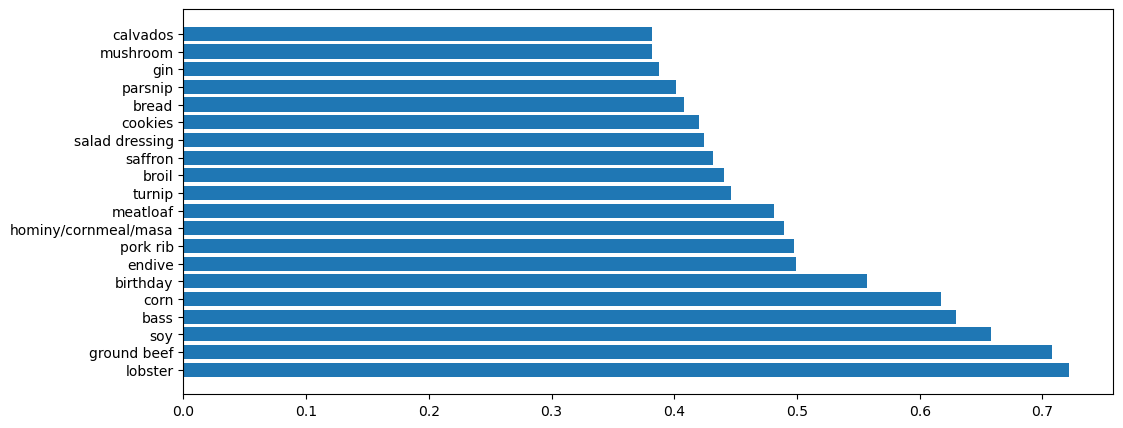

In [73]:
f_importances(abs(mod_clf2_m[1].coef_[0]), X_train.columns, top=20)

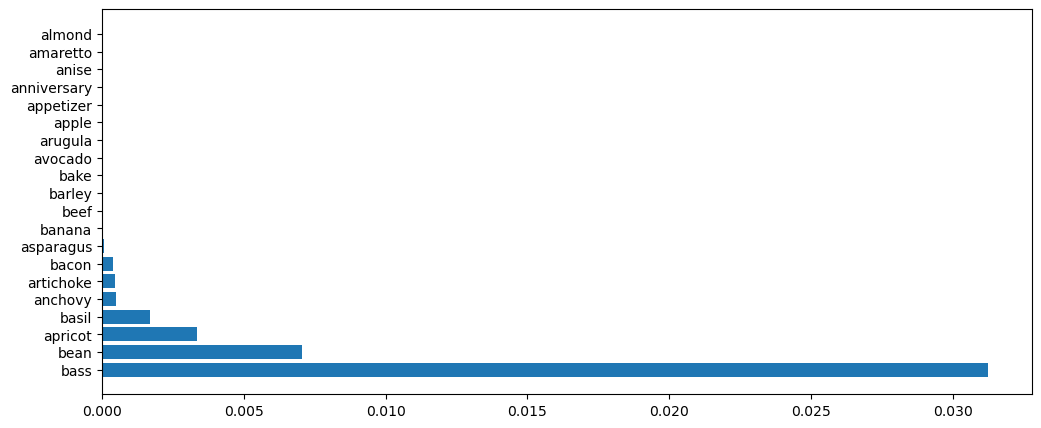

In [74]:
f_importances(abs(mod_clf2_m[2].feature_importances_[0:20]), X_train.columns, top=20)

#### 1.3.6 Снова рассчитайте значение accuracy наивного классификатора, в котором вы для всех наблюдений прогнозируете наиболее распространенный класс. Сравните метрики.

In [75]:
top_class = y_train.value_counts()[:1].index.tolist()[0]
acc_naiv_clf = sum(y_test == top_class)/len(y_test)
print("Наиболее распространенный класс:", top_class)
print("Значение accuracy наивного классификатора: %0.5f" % acc_naiv_clf)

Наиболее распространенный класс: great
Значение accuracy наивного классификатора: 0.79544


Метрики наивного прогноза не сильно отличаются от метрик классификааторов с подобранными гиперпараметрами.

#### 1.3.7 Что хуже: спрогнозировать плохой рейтинг, который на самом деле окажется хорошим, или спрогнозировать хороший рейтинг, который на самом деле окажется плохим? Замените метрику accuracy другой соответствующей метрикой.

Спрогнозировать хороший рейтинг, который на самом деле окажется плохим - хуже, чем спрогнозировать плохой рейтинг который окажется хорошим. При такой постановке вопроса, контроль за предсказанием хорошего рейтинга должен быть жестче, чем за предсказаением плохого рейтинга. 

https://pythonru.com/baza-znanij/metriki-accuracy-precision-i-recall

`Метрика accuracy`

"Accuracy — это показатель, который описывает общую точность предсказания модели по всем классам. Это особенно полезно, когда каждый класс одинаково важен. Он рассчитывается как отношение количества правильных прогнозов к их общему количеству."

"Стоит учесть, что метрика accuracy может быть обманчивой. Один из таких случаев — это несбалансированные данные. Предположим, у нас есть всего 600 единиц данных, из которых 550 относятся к классу Positive и только 50 — к Negative. Поскольку большинство семплов принадлежит к одному классу, accuracy для этого класса будет выше, чем для другого.

Если модель сделала 530 правильных прогнозов из 550 для класса Positive, по сравнению с 5 из 50 для Negative, то общая accuracy равна (530 + 5) / 600 = 0.8917. Это означает, что точность модели составляет 89.17%. Полагаясь на это значение, вы можете подумать, что для любой выборки (независимо от ее класса) модель сделает правильный прогноз в 89.17% случаев. Это неверно, так как для класса Negative модель работает очень плохо."

Баланс классов в процентах:

In [76]:
y_train.value_counts(normalize=True)

great    0.795349
so-so    0.106659
bad      0.097992
Name: rating, dtype: float64

Наши классы сильно несбалансированы. Поэтому метрика accuracy не дает реального представления о том на сколько хорошо работает наша модель.

`Метрика recall`

"Recall заботится только о том, как классифицируются Positive выборки. Эта метрика не зависит от того, как предсказываются Negative семплы, в отличие от precision. Когда модель верно классифицирует все Positive выборки, recall будет 100%, даже если все представители класса Negative были ошибочно определены как Positive"

Эта метрика не подходит, так как не контролирует избыточное предсказание хорошего рейтинга

`Метрика precision.`

"Precision представляет собой отношение числа семплов, верно классифицированных как Positive, к общему числу выборок с меткой Positive (распознанных правильно и неправильно). Precision измеряет точность модели при определении класса Positive.
Precision отражает, насколько надежна модель при классификации Positive-меток". 

Это именно та метрика которая нужна для контроля за предсказанием хорошего рейтинга.

#### 1.3.8 Для прогнозирования классов с новой метрикой опробуйте различные алгоритмы и их гиперпараметры. Выберите лучшее решение и посчитайте метрику на тестовой подвыборке

https://scikit-learn.ru/3-3-metrics-and-scoring-quantifying-the-quality-of-predictions/

- ""micro" дает каждой паре выборка-класс равный вклад в общую метрику (за исключением результата взвешивания выборки). Вместо того, чтобы суммировать метрику для каждого класса, это суммирует дивиденды и делители, составляющие метрики для каждого класса, для расчета общего частного. Микро-усреднение может быть предпочтительным в настройках с несколькими ярлыками, включая многоклассовую классификацию, когда класс большинства следует игнорировать."


Так как в датасете очень несбалансированные классы, из за чего модель может давать много ложных прогнозов преобладающего класса "great", то значение "micro", на мой взгляд, подходит для наших данных

##### Метрика - precision

In [77]:
precision_scorer = make_scorer(
    precision_score, 
    greater_is_better=True, # чем болше, тем лучше 
    average='weighted',# учет дисбаланса классов
    )

##### Precision для наивного классификатора 0.6327

In [78]:
top_class = y_train.value_counts()[:1].index.tolist()[0]
y_naiv = pd.Series(top_class, index=range(len(y_test)))
precision_score(y_test, y_naiv, average='weighted')

0.6327280784525886

##### 1.3.8.1 Выбор алгоритма классификатора с новой метрикой

In [79]:
#   3. Алгоритмы для Precision
# ? -----------------------------------
res_clf3_a, mod_clf3_a = run_select(
    X_train, y_train, X_valid, y_valid,
    './results/clf3_best_alg.csv', 
    'No', # модели не сохранять
    m_select,
    algs_clf, 
    set_algs_clf, 
    'gscv', 
    precision_scorer, 
    cv=10,
    scor_test=True, # проводить проверку на тесте
    time_drop=False # не удалять из вывода время на поиск
)
res_clf3_a
# ? -----------------------------------

,model,test_score,train_score,time,params
0,RandomForestClassifier,0.71132,0.72421,10.747,{}
1,LinearDiscriminantAnalysis,0.71012,0.71430,2.370,{}
2,LogisticRegression,0.70716,0.71442,3.357,{}
3,SVC,0.70645,0.70877,166.106,{}
4,MLPClassifier,0.70574,0.70204,83.549,{}
5,GradientBoostingClassifier,0.70281,0.71018,29.084,{}
6,RidgeClassifier,0.70239,0.70161,2.153,{}
7,AdaBoostClassifier,0.69548,0.70947,5.001,{}
8,ExtraTreesClassifier,0.69544,0.70606,15.734,{}
9,KNeighborsClassifier,0.68904,0.69194,1.014,{}


##### 1.3.8.2 Балансировка классов - Ресамплинг

In [80]:
df_cut_train = pd.concat([X_train, y_train], axis=1)
great = df_cut_train[df_cut['rating']=='great']
so_so = df_cut_train[df_cut['rating']=='so-so']
bad = df_cut_train[df_cut['rating']=='bad']

In [81]:
# Класс bad
bad_upsampled = resample(bad ,
                          replace=True, 
                          n_samples=len(great), 
                          random_state=21) 

# Класс so-so
so_so_upsampled = resample(so_so ,
                          replace=True, 
                          n_samples=len(great), 
                          random_state=21) 

In [82]:
# Новый датасет
df_sample = pd.concat([great, bad_upsampled, so_so_upsampled])

Теперь классы сбалансированы

In [83]:
y = df_sample['rating']
y.value_counts(normalize=True)

bad      0.333333
so-so    0.333333
great    0.333333
Name: rating, dtype: float64

In [84]:
X_train = df_sample.drop(['rating'],axis=1)
y_train = df_sample['rating']

--------------------------

##### 1.3.8.3 Выбор алгоритма классификатора с новой метрикой и ребалансом классов

In [87]:
algs_clf = []
set_algs_clf = []
# Линейные алгоритмы:
algs_clf.append(RidgeClassifier()) 
set_algs_clf.append({})
algs_clf.append((LogisticRegression()))
set_algs_clf.append({})
algs_clf.append((LinearDiscriminantAnalysis()))
set_algs_clf.append({})
# Нелинейные алгоритмы:
algs_clf.append((KNeighborsClassifier()))
set_algs_clf.append({})
algs_clf.append((DecisionTreeClassifier()))
set_algs_clf.append({})
# algs_clf.append((LinearSVC()))
# set_algs_clf.append({})
# algs_clf.append((SVC()))
# set_algs_clf.append({})
# Алгоритм искусственной нейронной сети:
algs_clf.append((MLPClassifier()))
set_algs_clf.append({})
# Ансамблевые алгоритмы:
algs_clf.append((AdaBoostClassifier(algorithm='SAMME')))
set_algs_clf.append({})
algs_clf.append((RandomForestClassifier()))
set_algs_clf.append({})
algs_clf.append((BaggingClassifier()))
set_algs_clf.append({})
algs_clf.append((ExtraTreesClassifier()))
set_algs_clf.append({})
algs_clf.append((GradientBoostingClassifier()))
set_algs_clf.append({})

In [89]:
#   4. Алгоритмы для Ресамплинга и Precision
# ? -----------------------------------
res_clf4_a, mod_clf4_a = run_select(
    X_train, y_train, X_valid, y_valid,
    './results/clf4_best_alg.csv', 
    'No', # модели не сохранять
    m_select,
    algs_clf, 
    set_algs_clf, 
    'gscv', 
    precision_scorer, 
    cv=10,
    scor_test=False, # проводить проверку на тесте
    time_drop=False # не удалять из вывода время на поиск
)
res_clf4_a
# ? -----------------------------------

,model,train_score,time,params
0,ExtraTreesClassifier,0.97673,35.644,{}
1,RandomForestClassifier,0.96745,24.352,{}
2,MLPClassifier,0.94422,149.005,{}
3,BaggingClassifier,0.92714,27.529,{}
4,DecisionTreeClassifier,0.91042,4.286,{}
9,KNeighborsClassifier,0.79584,4.684,{}
6,GradientBoostingClassifier,0.58636,72.626,{}
7,LogisticRegression,0.57385,7.101,{}
8,RidgeClassifier,0.56709,1.198,{}
5,LinearDiscriminantAnalysis,0.56464,6.019,{}


In [200]:
# -----------------------------------------
# 
# -----------------------------------------
# mod_len = ExtraTreesClassifier(random_state=21)
# mod_len.fit(X_train, y_train)
# saving_model(mod_len,'./models/ETClf(0.95880)_1.sav')

##### 1.3.8.3 Гиперпараметры классификаторов с новой метрикой и ребалансом

In [90]:
mdls_clf4 = []
set_mdls_clf4 = []
# ---------------------------
mdls_clf4.append(ExtraTreesClassifier(random_state=21))
set_mdls_clf4.append( {
    'class_weight':['balanced'],
    'n_estimators':[int(x) for x in np.linspace(5, 1000, 4)],
    # 'criterion':["gini","entropy","log_loss"],
    'max_depth':[int(x) for x in np.linspace(2, 50, 3)],
    'min_samples_split':[int(x) for x in np.linspace(2, 5, 3)],
    'min_samples_leaf':[int(x) for x in np.linspace(1, 5, 3)],
    # 'bootstrap': [True, False],
})
# ---------------------------
# fit_intercept=False,
mdls_clf4.append(RandomForestClassifier(random_state=21))
set_mdls_clf4.append({
    'class_weight':['balanced'],
    'n_estimators':[int(x) for x in np.linspace(5, 1000, 4)],
    # 'criterion':["gini","entropy","log_loss"],
    'max_depth':[int(x) for x in np.linspace(2, 50, 3)],
    'min_samples_split':[int(x) for x in np.linspace(2, 5, 3)],
    'min_samples_leaf':[int(x) for x in np.linspace(1, 5, 3)],
    # 'bootstrap': [True, False],
})

# ---------------------------
mdls_clf4.append(DecisionTreeClassifier(random_state=21))
set_mdls_clf4.append({
    'class_weight':['balanced'],
    'splitter':['best', 'random'],
    # 'criterion':["gini","entropy","log_loss"],
    'max_depth':[int(x) for x in np.linspace(2, 50, 3)],
    'min_samples_split':[int(x) for x in np.linspace(2, 5, 3)],
    'min_samples_leaf':[int(x) for x in np.linspace(1, 5, 3)],
})

In [91]:
#   3. Гиперпараметры для классификаторов с новой метрикой
# ? -----------------------------------
res_clf4_m, mod_clf4_m = run_select(
    X_train, y_train, X_test, y_test,
    './results/clf4_best_mod.csv', 
    './results/clf4_best_mod.sav',
    m_select,
    mdls_clf4, 
    set_mdls_clf4, 
    'gspb', 
    precision_scorer, 
    cv=5,
    scor_test=True, # проводить проверку на тесте
    time_drop=True
)
res_clf4_m
# ? -----------------------------------

,model,test_score,train_score,params
0,ExtraTreesClassifier,0.76249,0.98420,"{'class_weight': 'balanced', 'n_estimators': 6..."
1,RandomForestClassifier,0.75673,0.98277,"{'class_weight': 'balanced', 'n_estimators': 1..."
2,DecisionTreeClassifier,0.58347,0.96374,"{'class_weight': 'balanced', 'splitter': 'rand..."


Топ-20 важных признаков

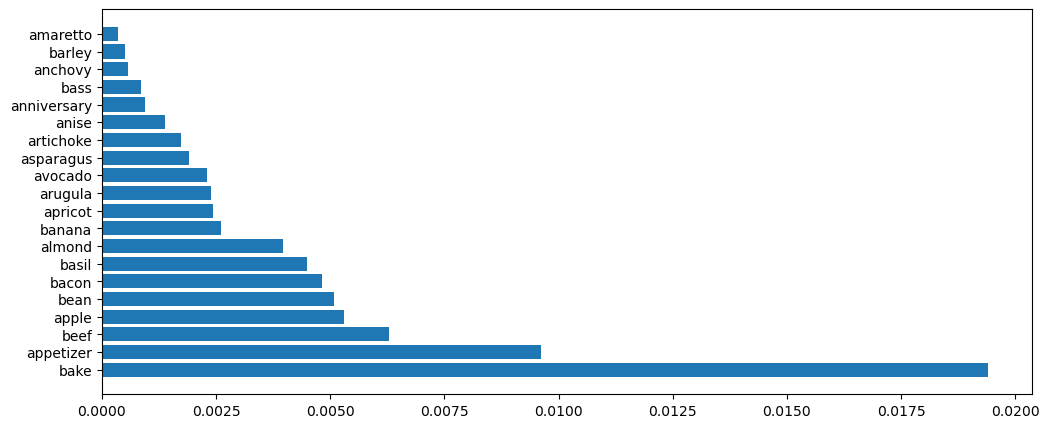

In [92]:
f_importances(abs(mod_clf4_m[0].feature_importances_[0:20]), X_train.columns, top=20)

#### 1.3.9 Попробуйте различные ансамбли и их гиперпараметры. Выберите лучшее решение и посчитайте метрику на тестовой подвыборке.

##### 1.3.9.1 Обучить лучшие модели перед использованием в ансамблях

`Модели обучены на предыдущем этапе`

##### 1.3.9.2 Подбор гиперпараметров для ансамблей классификаторов

In [93]:
ens_clf = []
ens_clf_set = []

estimators = [
    ('etclf',mod_clf4_m[0]),
    ('rfclf',mod_clf4_m[1]),
    ('dtclf',mod_clf4_m[2]),
]

skfolds = []
for i in range(2, 10):
    skfolds.append(StratifiedKFold(shuffle=True, random_state=21))

# -----------------------------------------------------
ens_clf.append(StackingClassifier(estimators=estimators))
ens_clf_set.append({
    'final_estimator': [
        RandomForestClassifier()
        ],
    'cv': skfolds,
})
# -----------------------------------------------------
ens_clf.append(VotingClassifier(estimators=estimators))
ens_clf_set.append({
    'weights': [[1,2,3],[3,2,1],[2,3,1],[3,1,2]],
})
# ---------------------------
ens_clf.append(BaggingClassifier(random_state=21))
ens_clf_set.append({
    #int, default=10
    'n_estimators':[int(x) for x in np.linspace(5, 100, 4)],
    #bool, default=True
    'bootstrap':[True, False],
    #bool, default=False
    'bootstrap_features':[True, False],
})

In [94]:
#    Гиперпараметры для ансамблей
# ? -----------------------------------
res_clf4_e, mod_clf4_e = run_select(
    X_train, y_train, X_test, y_test,
    './results/clf4_best_ens_pb.csv', 
    './results/clf4_best_ens_pb.sav',
    m_select,
    ens_clf, 
    ens_clf_set, 
    'gspb', 
    precision_scorer, 
    cv=5,
    scor_test = True # проводить проверку на тесте
)
res_clf4_e
# ? -----------------------------------

,model,test_score,train_score,params
0,StackingClassifier,0.79325,0.99451,"{'final_estimator': RandomForestClassifier(), ..."
1,BaggingClassifier,0.78171,0.98983,"{'n_estimators': 100, 'bootstrap': False, 'boo..."
2,VotingClassifier,0.75975,0.98240,"{'weights': [3, 2, 1]}"


### 1.4 Принятие решения

- Примите решение о том, что лучше использовать: регрессионную модель или классификацию. Сохраните выбранную модель. Вы будете использовать ее в основной программе.

Метрики лучших регрессионных моделей (RMSE: `-1.24597`) не сильно отличаются от метрики наивного регрессора (RMSE: `-1.32974`). Метрики лучших классификаторов на тестовой выборке (Precision: `0.79325`) лучше метрики наивного классификатора (Precision: `0.6327`).

Лучше использовать классификацию.

In [206]:
# -----------------------------------------
#  Сохранение модели
# -----------------------------------------
# saving_model(mod_clf4_e[0],'./models/StackingClassifier(0.79325).sav')

Models saved!


## 2. Пищевая ценность

- Соберите в датафрейм всю информацию о пищевой ценности продуктов из подготовленного вами и отфильтрованного набора данных (только столбцы с продуктами). Используйте для этого следующий API.
- Конвертируйте все значения в % от суточной нормы потребления. Сохраняйте только те ингридиенты, которые находятся в этой и этой таблицах.
- Сохраните измененный датафрейм в CSV-файл, который вы будете использовать в своей основной программе.

In [95]:
# Чтение из pdf
from tabula import read_pdf
df_nutr_0 = read_pdf(".\data\Daily-Reference-Values-_DRVs_-under-the-New-NFL.pdf", pages="all")
df_nutr_0 = df_nutr_0[0]
headers = df_nutr_0.iloc[0]
df_nutr_0  = pd.DataFrame(df_nutr_0.values[1:], columns=headers)
df_nutr_0 

,Food\rComponent,Unit of measure,Adults and Children ≥ 4\ryears,Infants through 12\rmonths,Children 1 through 3\ryears,Pregnant women and\rlactating women
0,Fat,Grams (g),178,30,239,178
1,Saturated fat,Grams (g),120,N/A,210,120
2,Cholesterol,Milligrams (mg),300,N/A,300,300
3,Total\rcarbohydrates,Grams (g),1275,95,2150,1275
4,Sodium,Milligrams (mg),"2,300",N/A,"1,500","2,300"
5,Dietary Fiber,Grams (g),128,N/A,214,128
6,Protein,Grams (g),150,N/A,213,N/A
7,Added sugars,Grams (g),150,N/A,225,150


In [96]:
# Чтение из pdf
from tabula import read_pdf
df_nutr_1 = read_pdf(".\data\Reference-Daily-Intakes-_RDIs_-in-the-New-Nutrition-Facts-Label.pdf", pages="all")
df_nutr_1 = df_nutr_1[0]
headers = df_nutr_1.iloc[0]
df_nutr_1  = pd.DataFrame(df_nutr_1.values[1:], columns=headers)
df_nutr_1.head() 

,Nutrient,Unit of measure,Adults and Children\r≥ 4 years,1Infants through 12\rmonths,Children 1 through 3\ryears,Pregnant women\rand lactating women
0,Vitamin A,Micrograms RAE2 (mcg),900,500,300,"1,300"
1,Vitamin C,Milligrams (mg),90,50,15,120
2,Calcium,Milligrams (mg),"1,300",260,700,"1,300"
3,Iron,Milligrams (mg),18,11,7,27
4,Vitamin D,Micrograms (mcg)3,20,10,15,15


In [97]:
# Редакция имен столбцов и содание объединенного df нутриентов
# --------------------------------------------
df_nutr_0.rename({'Food\rComponent':'Nutrient'},axis=1,inplace=True)

df_nutr_0.rename({'Infants through 12\rmonths':'Infants through 12 months'},axis=1,inplace=True)
df_nutr_1.rename({'1Infants through 12\rmonths':'Infants through 12 months'},axis=1,inplace=True)

df_nutr_0.rename({'Pregnant women and\rlactating women':'Pregnant women and lactating women'},axis=1,inplace=True)
df_nutr_1.rename({'Pregnant women\rand lactating women':'Pregnant women and lactating women'},axis=1,inplace=True)

df_nutr_0.rename({'Adults and Children ≥ 4\ryears':'Adults and Children ≥ 4 years'},axis=1,inplace=True)
df_nutr_1.rename({'Adults and Children\r≥ 4 years':'Adults and Children ≥ 4 years'},axis=1,inplace=True)

df_nutr_0.rename({'Adults and Children ≥ 4\ryears':'Adults and Children ≥ 4 years'},axis=1,inplace=True)
df_nutr_1.rename({'Adults and Children\r≥ 4 years':'Adults and Children ≥ 4 years'},axis=1,inplace=True)
# --------------------------------------------
df_nutr = pd.concat([df_nutr_0, df_nutr_1], ignore_index=True)

In [98]:
# --------------------------------------------
api_key = 'jxa3IoyvuTRnSoB2BHOGyh3iWINu5uZEjZgyHA24'

In [99]:
# --------------------------------------------
# Функция
# --------------------------------------------
def nutrient_explorer():
    ''' 
    Собирает информацию по указанным нутриентам для указанных ингредиентов
    
    '''
    # --------------------------------------------
    # Создать датафрейм размером len(X.columns) X len(df_nutr['Nutrient']) заполненный 0
    # --------------------------------------------
    dict_n = {'ingr':X.columns.to_list()}
    for ingred in df_nutr['Nutrient']:
        dict_n[ingred] = [0]*len(X.columns)
    dict_dff = pd.DataFrame(dict_n)
    dict_dff = dict_dff.set_index('ingr')
    # --------------------------------------------
    log_err = [] # сбор информации об ощибках
    # --------------------------------------------
    for i, ingr in  enumerate(dict_dff.index): # итерация по строкам-ингредиентам
        print(f"Собрано {i} из {dict_dff.shape[0]}")
        try:
            url_api = f'https://api.nal.usda.gov/fdc/v1/foods/search?query={ingr}&api_key={api_key}'
            request = requests.get(url_api).json()
            nutrs = request['foods'][0]['foodNutrients']
            # --------------
            print(ingr)
            # Нутриенты по ингредиенту
            for j, nutr in enumerate(nutrs): # итерация по колонкам-нутриентам
                dkey = nutr['nutrientName']
                if dkey in dict_dff.columns:
                    print("in df_nutr['Nutrient']", dkey, nutr['value'])
                    dict_dff.at[ingr, dkey] = nutr['value']
        except:
            log_err.append(ingr) # сохранить все неудачные попытки
            print(f"Информацию об{ingr},собрать не удалось")

        # if i==10: break

    # --------------------------------------------
    # Сохранить результат в файл
    dict_dff.to_csv('./data/NUTR_FRAME.csv') # датафрейм
    saving_model(log_err, './data/log_err_nutr_frame.list') # ошибки

    return dict_dff


In [100]:
# --------------------------------------------
# Время работы ф-ии может быть очень долгим!
# --------------------------------------------
# dict_dff = nutrient_explorer()

In [101]:
dict_dff = pd.read_csv('./data/NUTR_FRAME.csv')
dict_dff

,ingr,Fat,Saturated fat,Cholesterol,Total\rcarbohydrates,Sodium,Dietary Fiber,Protein,Added sugars,Vitamin A,...,Magnesium,Zinc,Selenium,Copper,Manganese,Chromium,Molybdenum,Chloride,Potassium,Choline
0,almond,0,0,0,0,0,0,21.00,0,0,...,0,0,0,0,0,0,0,0,0,0
1,amaretto,0,0,0,0,0,0,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0
2,anchovy,0,0,85,0,0,0,28.90,0,0,...,0,0,0,0,0,0,0,0,0,0
3,anise,0,0,0,0,0,0,17.60,0,0,...,0,0,0,0,0,0,0,0,0,0
4,anniversary,0,0,65,0,0,0,4.62,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,green onion/scallion,0,0,0,0,0,0,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0
405,hominy/cornmeal/masa,0,0,4,0,0,0,1.45,0,0,...,0,0,0,0,0,0,0,0,0,0
406,phyllo/puff pastry dough,0,0,0,0,0,0,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0
407,soufflé/meringue,0,0,0,0,0,0,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Похожие рецепты

- Для каждого рецепта из набора данных найдите ссылку на сайте epicurious.com и подробную информацию о нем (название рецепта, рейтинг на платформе и URl). Если сделать это не удалось, найдите для данного рецепта похожую ссылку в Интернете.
- Сохраните новый датафрейм в CSV-файл, который вы будете использовать в своей основной программе.

In [102]:
# -------------------------------------------
# Функция. Проверка символов запросной строки
# -------------------------------------------
def check_query(query_string):
    ''' 
    Проверка символов из которых состоит будущая строка запроса
    Просто выводит все уникальные символы
    '''
    unique_chars = set()
    for ttl in query_string:
        for char in ttl.lower():
            unique_chars.add(char)
    print(sorted(unique_chars))

In [103]:
# -------------------------------------------
# Функция. Очищение запросной строки
# -------------------------------------------
def clean_query(query):
    symb = set()
    for ttl in query:
        ttl = re.sub(r"[\W]+", " ", ttl) 
        # ttl = re.sub(r"[\d]+", " ", ttl)
        ttl = re.sub(r"à|á|â|ã|ä", "a", ttl)
        ttl = re.sub(r"è|é|ê|ë|é", "e", ttl)
        ttl = re.sub(r"í|î|ï", "i", ttl)
        ttl = re.sub(r"ó|ô|ö|ø", "o", ttl)
        ttl = re.sub(r"ú|û|ü|ù", "u", ttl)
        ttl = re.sub(r"ç", "c", ttl)
        ttl = re.sub(r"ñ", "n", ttl)

        for char in ttl.lower():
            symb.add(char)
    print(sorted(symb))

In [104]:
# -------------------------------------------
# Функция. Получение ссылки на сайте https://www.epicurious.com 
# -------------------------------------------
def get_url(title): 
    result = None 
    try:
        url = f'https://www.epicurious.com/search/{title}?content=recipe'
        # Получаем ответ
        request = requests.get(url)
        # Обрабатываем ответ
        soup = bs(request.text, "html.parser")
        # Ищем рецепт
        tree = soup.find(class_="show-quick-view", title=title)
        
        if not tree:
            tree = soup.find(class_="show-quick-view")
        if tree:
            result = f"https://www.epicurious.com{tree['href']}"
        return result
    except:
        print("Ошибка. Информацию о {title} собрать не удалось")

In [105]:
# -------------------------------------------
# Функция. Поиск нужных ссылок на сайте https://www.epicurious.com 
# -------------------------------------------
def search_url(df_urls, collector, stop):
    # for i, title in enumerate(collector.index):
    for i, title in enumerate(collector):
        url = get_url(title)
        if url:
            df_urls.at[title, 'url'] = url
        
        print(i, title)
        
        if i == stop: break 


In [106]:
# -------------------------------------------
# Поиск в Google тех ссылок которые не нашлись на https://www.epicurious.com
# -------------------------------------------
def find_google(df_urls, collector, stop):
    for i, title in enumerate(collector):
        print(i, title)
        query = title
        try:
            for url in search(query, tld="co.in", num=1, stop=1, pause=1):
                df_urls.at[title, 'url'] = url
        except HTTPError:
            print("HTTPError ")
        
        if i == stop: break 


In [108]:
# -------------------------------------------
# Запуск ф-ии поиска ссылок. 
# -------------------------------------------
def run_search(epicur, df_urls):

    if epicur:
        # ----- https://www.epicurious.com ----------
        search_url(df_urls, collector, 50)
    else:
        # --------------- Google ---------------------
        find_google(df_urls, collector, 25)
        # -------------------------------------------

    df_urls.to_csv('./data/URLS_RECIPS.csv')

In [109]:
# Подготовка
# -------------------------------------------
file_path = './data/URLS_RECIPS.csv' # Файл с сохраненными ссылками

if os.path.isfile(file_path): # если существует - загрузить в df_urls
    df_urls = pd.read_csv(file_path)
else: # --------------------- если НЕ существует - создать df_urls
    # Создать список запросных строк из title очищенного датасета
    # -------------------------------------------
    title_clean = title.to_list()
    # посмотреть из каких символов состоит список
    check_query(title_clean) 
    # Очистить список запросных строк
    # -------------------------------------------
    clean_query(title_clean) # выведет те символы которые остались
    # Создать df для сбора ссылок
    # -------------------------------------------
    df_urls = pd.DataFrame({'title':title_clean, 'url':'0'})
    
df_urls = df_urls.set_index('title')

# Создать список из рецептов для которых не собраны ссылки
# -------------------------------------------
collector = df_urls[df_urls['url'] == '0'].index.to_list()
print(f"Нужно собрать {len(collector)} ссылок")

Нужно собрать 0 ссылок


In [110]:
# -------------------------------------------
# Запуск ф-ии поиска ссылок. 
# -------------------------------------------
# run_search(True, df_urls)